cropped_yale_eigenface

## <center>Face Recognition<center>

The Extended Yale Facedatabase B contains 2414 images of 39 different people in its cropped version

try 3 different Face-recognition approaches: KNN, PCA, Convolutional Neural Network(CNN)
    
to check their advantages and disadvantages under different scenario

### <center> Load Data<center>

In [3]:
%matplotlib inline  
import pandas as pd
import numpy as np
import os,sys
from sklearn.model_selection import train_test_split

import logging
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from time import time
from sklearn.pipeline import Pipeline


In [4]:
from PIL import Image
import numpy as np
import glob

# File Link
path = '/Users/minfang/Documents/Min/Study/Math/Statistics/SJSU MATH 251 Classification/project/face recognition/CroppedYale'
def read_images(path, sz=(168,192), matrix = False, normalization = False): 
    t0 = time() # time reading images
    c=0 # count of read images
    
    # y to store subject number of images read
    y = [] 
    # Images are resized to 168x192
    # x to store all image data
    if matrix == False:
        x = np.empty([1, 32256]) 
    else: 
        x = np.empty((1,sz[1], sz[0]))
    for dirname , dirnames , filenames in os.walk(path):
        # loop all directories, sub-dir, files to read images
        # in data folder of this project, only 1st dirnames is valid, others are empty list (no subfolder)
        for subdirname in dirnames:
            subject_path = os.path.join(dirname , subdirname) 
            for filename in os.listdir(subject_path):
                # read files start with 'yale'
                # eclude windows hidden files of 'desktop.ini'
                if filename[:4] != 'yale':
                    continue
                
                # for files start with 'yale'
                # 1. read image
                # 2. convert images from RGB to L(color to black/white)
                # In this project, all images are greyscale images, run this step in case of exceptions
                # 3. resize image to 168 X 192
                # In this project, all images are 168 X 192, run this step in case of exceptions
                # 4. read images to matrix (ndarray)
                # 5. normalize image matrix
                # 6. flatten image ndarray (2-d to 1-d)
                # 7. store image ndarray to data (x)
                try:
                    im = Image.open(os.path.join(subject_path , filename)) 
                    im = im.convert("L")
                    # resize to given size (if given)
                    if (sz is not None):
                        im = im.resize(sz, Image.ANTIALIAS)
                    im  = np.asarray(im, dtype=np.uint8)
                    im.flags.writeable = True # set ndarray as writeable. not read-only
                    
                    # Normalization
                    if normalization == True:
                        im = (im - im.mean())/im.std()

                    # Convert 2-d ndarray images to 1-d array by rows through ndarray.ravel()
                    # append image array to x
                    # first element is empty array
                    if matrix == False:
                        x = np.vstack((x,im.ravel()))
                    else: 
                        x = np.vstack((x, [im]))
                    # y.append(c)
                    # append image subject number to label data: y
                    y.append(filename[5:7])
                except IOError:
                    #print "I/O error({0}): {1}".format("errno", "strerror") #there is some text files in the path
                    pass
                except:
                    print ("Unexpected error:", sys.exc_info()[0] )
                    raise
            c = c+1
        
    y = np.asarray(y)
    x = x[1:] # Skip the first line which is void
    print("Image read in %0.3fs" % (time() - t0))
    return [x,y]

### <center> train test split<center>

In [5]:
%%time
x,y = read_images(path=path, normalization = True)

Image read in 417.331s
CPU times: user 5min 44s, sys: 4min 19s, total: 10min 3s
Wall time: 6min 57s


In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [7]:
# check train, test data shape and labels
print("x data  size: ", x.shape[0])
print("y data  size: ", y.shape[0])
print("x_train size: ", x_train.shape[0])
print("y_trian size: ", y_train.shape[0])
print("x_test  size: ", x_test.shape[0])
print("y_test  size: ", y_test.shape[0])

r_unique, r_counts = np.unique(y_train, return_counts=True)
t_unique, t_counts = np.unique(y_test, return_counts=True)

print("\nTrain set labels: ", r_unique)
print("Train set counts: ", r_counts)
print("Test  set labels: ", t_unique)
print("Test  set counts: ", t_counts)

x data  size:  2410
y data  size:  2410
x_train size:  2169
y_trian size:  2169
x_test  size:  241
y_test  size:  241

Train set labels:  ['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39']
Train set counts:  [57 59 58 59 51 58 51 54 58 58 54 53 54 56 53 60 63 57 59 61 57 57 59 57
 58 57 57 58 55 56 53 61 60 57 55 59 60 60]
Test  set labels:  ['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '15'
 '16' '17' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32' '33' '34' '35' '36' '37' '38' '39']
Test  set counts:  [ 7  4  5  5 12  6 13 10  6  6  6  6  6  7  9  3  7  5  3  7  7  5  7  6
  6  7  6  9  8 11  3  4  7  9  5  4  4]


In [ ]:
train_size = pd.DataFrame({'label':r_unique,'train_size':r_counts,})
train_size

In [ ]:
test_size = pd.DataFrame({'label':t_unique,'test_size':t_counts,})
test_size

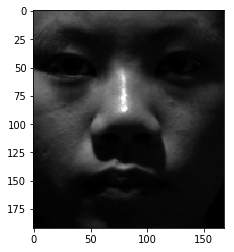

<Figure size 432x288 with 0 Axes>

In [8]:
#print(x_test[10].reshape(168, 192))
im0 = x_train[0].reshape(192, 168)
plt.imshow(im0, cmap = plt.get_cmap("gray"))
plt.show()
plt.clf()

### <center> PCA<center> 

In [9]:
from time import time
import logging
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import os,sys
import numpy as np
from sklearn.model_selection import train_test_split

In [10]:
from sklearn.decomposition import PCA
def eigenfaces(train, test,n_components=330):
    
    # Display progress logs on stdout
    logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

    print("Extracting the top %d eigenfaces from %d faces" % (n_components, x_train.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components, svd_solver='randomized',whiten=True).fit(x_train)
    eigenvalue = pca.explained_variance_
    eigenvector = pca.components_
    
    print("done in %0.3fs" % (time() - t0))
    
    #eigenfaces = pca.components_.reshape((n_components, h, w))
    
    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    train_pca = pca.transform(train)
    test_pca = pca.transform(test)

    print("EigenFaces done in %0.3fs" % (time() - t0))
    
    return train_pca, test_pca, eigenvalue, eigenvector

In [11]:
n = x_train.shape[0]
print(n)

2169


In [12]:
# EigenFaces
x_train_pca, x_test_pca, eigenvalues, eigenvectors = eigenfaces(x_train,x_test,n_components=n)

Extracting the top 2169 eigenfaces from 2169 faces
done in 66.930s
Projecting the input data on the eigenfaces orthonormal basis
EigenFaces done in 4.210s


In [13]:
# to normalize eigenvector due to that eigenvector contains negative numbers. 
# normalize to 0-255 to show as images
def normalize(X, low=0, high=255, dtype=None):
    X = np.asarray(X)
    minX, maxX = np.min(X), np.max(X)
    # normalize to [0...1].	
    X = X - float(minX)
    X = X / float((maxX - minX))
    # scale to [low...high].
    X = X * (high-low)
    X = X + low
    if dtype is None:
        return np.asarray(X)
    return np.asarray(X, dtype=dtype)

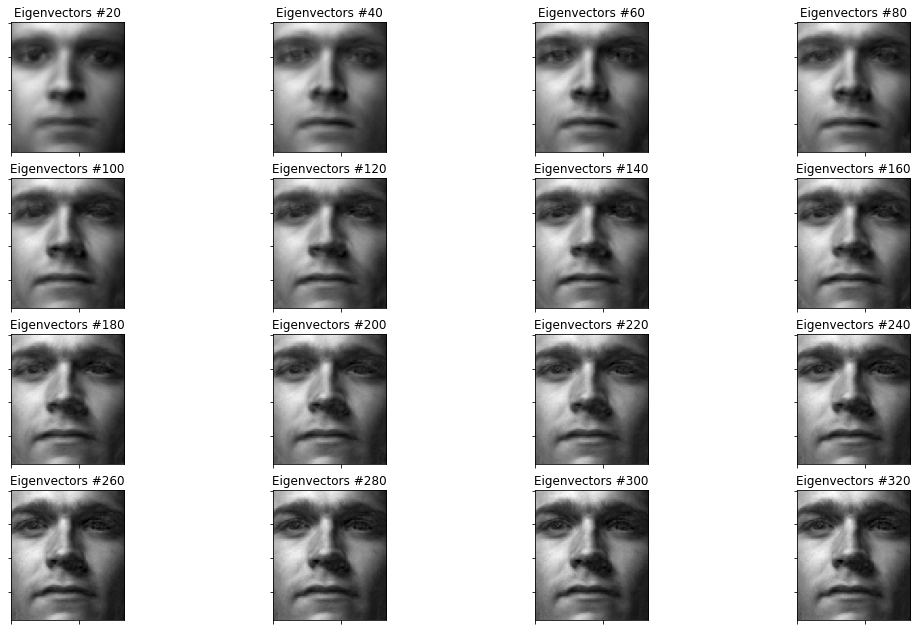

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.pyplot as plt
import mpld3

plt.rcParams['figure.figsize'] = [18,11]

steps =[i for i in range (20 , len (x), 20) ]
E = []
fig = plt.figure()
mu = x_train.mean(axis = 0)
for i in range ( min ( len ( steps ), 16) ):
    numEvs = steps [i]
    # reconstruct
    P = np.dot(x_train[100].reshape(1,-1) - mu, eigenvectors[0:numEvs, :].T)
    R = np.dot(P, eigenvectors[0:numEvs, :]) + mu
    
    # reshape
    R = R.reshape((192, 168) )
    E = normalize (R, 0, 255) 

    #fig.text(.5, .95, "Reconstructions", horizontalalignment='center') 
    ax0 = fig.add_subplot(4,4,(i+1))
    plt.setp(ax0.get_xticklabels(), visible=False)
    plt.setp(ax0.get_yticklabels(), visible=False)

    plt.title("%s #%d" % ("Eigenvectors", steps[i]))
    plt.imshow(np.asarray(E), cmap=cm.gray)
plt.show()    


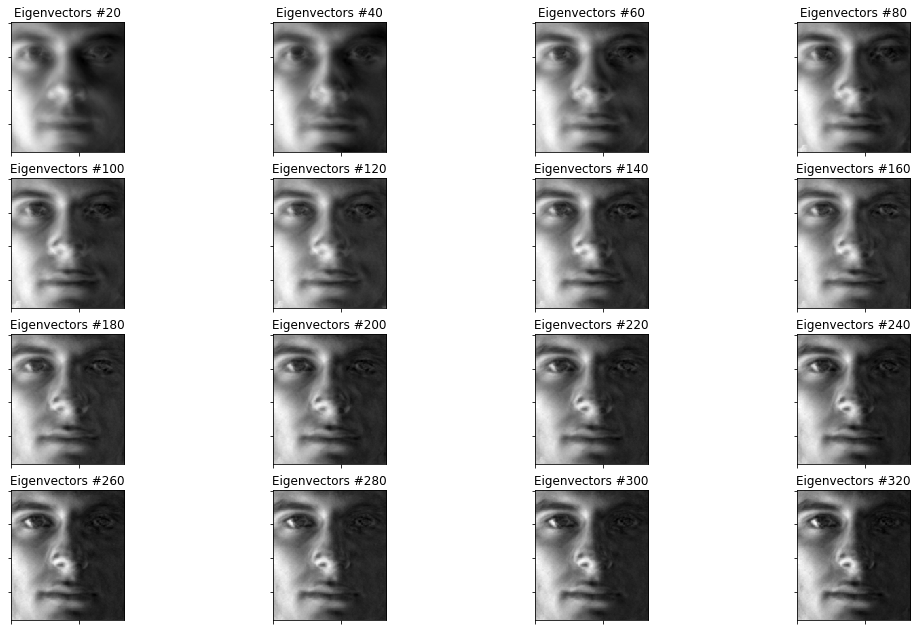

In [19]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.pyplot as plt
import mpld3

plt.rcParams['figure.figsize'] = [18,11]

steps =[i for i in range (20 , len (x), 20) ]
E = []
fig = plt.figure()
mu = x_train.mean(axis = 0)
for i in range ( min ( len ( steps ), 16) ):
    numEvs = steps [i]
    # reconstruct
    P = np.dot(x_train[200].reshape(1,-1) - mu, eigenvectors[0:numEvs, :].T)
    R = np.dot(P, eigenvectors[0:numEvs, :]) + mu
    
    # reshape
    R = R.reshape((192, 168) )
    E = normalize (R, 0, 255) 

    #fig.text(.5, .95, "Reconstructions", horizontalalignment='center') 
    ax0 = fig.add_subplot(4,4,(i+1))
    plt.setp(ax0.get_xticklabels(), visible=False)
    plt.setp(ax0.get_yticklabels(), visible=False)

    plt.title("%s #%d" % ("Eigenvectors", steps[i]))
    plt.imshow(np.asarray(E), cmap=cm.gray)
plt.show()    
